In [ ]:
import os
import sys
import json
import argparse
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)

        return x_cont, x_other, label

In [ ]:
class LSTM(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2):
        super(LSTM, self).__init__()
        # lstm part
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(dyn_channels, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 15)

        # fc part
        self.fc_static1 = nn.Linear(stat_channels,30)
        self.fc_static2 = nn.Linear(30,15)

        # fusion part
        self.fc_final1 = nn.Linear(30,2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_dynamic, x_static):
        h0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        c0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        out1, _ = self.lstm(x_dynamic, (h0, c0))
        out1 = self.relu(self.fc1(out1[:, -1, :]))
        out1 = self.relu(self.fc2(out1))

        out2 = self.relu(self.fc_static1(x_static))
        out2 = self.relu(self.fc_static2(out2))

        out = torch.cat((out1, out2), dim=1)
        out = self.fc_final1(out)

        return out


In [ ]:
trainval_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/train.pkl').reset_index(drop=True)

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)

N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [ ]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [ ]:
print(df_balanced.reset_index(drop=True).shape)

(35306, 35)


In [ ]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 2 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [ ]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(0)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [ ]:
def train(model,num_epochs,optimizer,criterion,train_loader, valid_loader, scheduler):
    if torch.cuda.is_available():
        model = model.cuda()
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in train_loader:
            model.train()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #y = y.float()
            pred = model(x_dynamic, x_static)

            loss = criterion(pred, y.reshape(-1))
            loss.backward()
            optimizer.step()
            #pred_labels = (torch.sigmoid(pred) > 0.5).float()
            total_loss += loss
            pred_labels = torch.argmax(pred, dim=-1)
            correct += (pred_labels == y).sum().item()
            #print(pred_labels)
            #print(y)
            total += y.shape[0]
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in valid_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #y = y.float()
            with torch.no_grad():
                pred = model(x_dynamic, x_static)
                pred_labels = torch.argmax(pred, dim=-1)
                loss = criterion(pred, y.reshape(-1))
                if scheduler:
                    scheduler.step(loss)
                total_loss += loss
                #pred_labels = (torch.sigmoid(pred) > 0.5).float()
                #pred_label = torch.argmax(pred, dim=-1)
                correct += (pred_labels == y).float().sum().item()
                total += y.shape[0]
            epoch_loss = total_loss / len(valid_loader)
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
model = LSTM(dyn_channels=5, stat_channels=32)
for m in model.modules():
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0001)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
          if 'weight_ih' in name:
            torch.nn.init.orthogonal_(param)
          elif 'weight_hh' in name:
            torch.nn.init.orthogonal_(param)
          elif 'bias' in name:
            param.data.fill_(0)

lr = 1e-4
num_epochs=30
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-4)
criterion= nn.CrossEntropyLoss()
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.9)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model,num_epochs,optimizer,criterion,train_loader, valid_loader, scheduler)

Epoch 1, Train Loss: 0.6133810877799988, Train Accuracy: 0.6650734643299699
Epoch 1, Validation Loss: 0.5915628671646118, Validation Accuracy: 0.6853136949440589
Epoch 2, Train Loss: 0.5820187330245972, Train Accuracy: 0.695025668259869
Epoch 2, Validation Loss: 0.5859033465385437, Validation Accuracy: 0.6914034839257895
Epoch 3, Train Loss: 0.5708774924278259, Train Accuracy: 0.7053991856965834
Epoch 3, Validation Loss: 0.5834654569625854, Validation Accuracy: 0.7037246848888259
Epoch 4, Train Loss: 0.5678563117980957, Train Accuracy: 0.7078420959461852
Epoch 4, Validation Loss: 0.587626576423645, Validation Accuracy: 0.708114997875655
Epoch 5, Train Loss: 0.5646398663520813, Train Accuracy: 0.7137900513365197
Epoch 5, Validation Loss: 0.5707686543464661, Validation Accuracy: 0.7054241608837275
Epoch 6, Train Loss: 0.5540026426315308, Train Accuracy: 0.7190653212958046
Epoch 6, Validation Loss: 0.5681403875350952, Validation Accuracy: 0.705990652882028
Epoch 7, Train Loss: 0.546353101

In [ ]:
train_loss_list = np.asarray([tensor.cpu().detach() for tensor in train_loss_list])
train_acc_list = np.asarray(train_acc_list)
valid_loss_list = np.asarray([tensor.cpu().detach() for tensor in valid_loss_list])
valid_acc_list = np.asarray(valid_acc_list)

In [ ]:
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/test.pkl').reset_index(drop=True)

class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)

N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)
batch_size=20


test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/lstm.pth')

Text(0.5, 1.0, 'Accuracy curve')

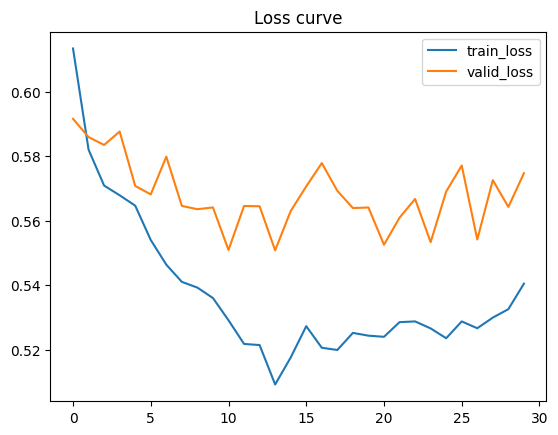

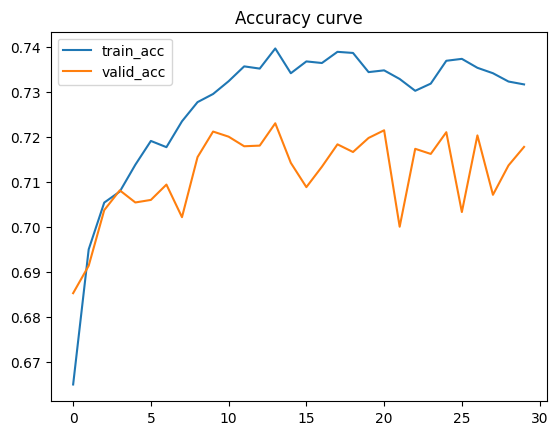

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
model = LSTM(dyn_channels=5, stat_channels=32)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/lstm.pth'))

<All keys matched successfully>

In [ ]:
model.cuda()
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()
            with torch.no_grad():
                pred = model(x_dynamic, x_static)

                #pred_labels = (torch.sigmoid(pred) > 0.5).float()
                pred_labels = torch.argmax(pred, dim=-1)
                correct += (pred_labels == y).float().sum().item()
                total += y.shape[0]
                y_true.append(y.reshape(-1).cpu().numpy())
                y_pred.append(pred_labels.reshape(-1).cpu().numpy())
print(correct/total)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.6805289993626513


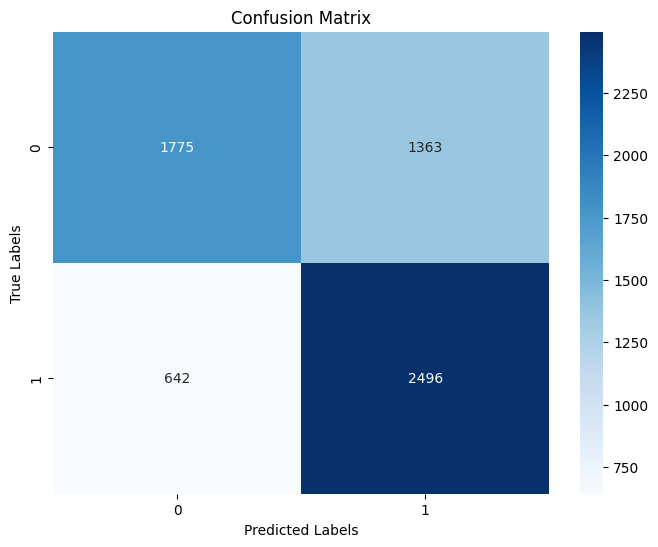

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name} has values: \n{param.data}")

lstm.weight_ih_l0 has values: 
tensor([[-1.1106e+00, -1.7583e+00, -3.3674e+00,  2.5602e-01, -6.1515e-01],
        [-3.9377e+00, -2.8290e+00,  1.2494e+00,  3.5648e-02, -2.1976e+00],
        [-4.6339e+00, -3.5256e+00,  1.5412e+00, -1.3013e+00, -1.9454e+00],
        [ 2.6245e+00, -7.7215e-02,  3.3420e+00,  6.7842e-01,  1.7010e+00],
        [ 1.3364e+00, -4.5415e+00,  9.9452e-02, -1.6628e+00,  4.0015e+00],
        [-3.2542e+00, -2.7944e+00,  2.5630e+00, -4.5121e+00, -1.7096e+00],
        [ 4.5968e-01, -1.1193e+00,  3.6965e+00, -4.1859e+00, -2.6462e+00],
        [ 3.5830e+00,  2.0433e+00,  2.4347e+00, -2.2695e+00,  4.9599e-01],
        [ 9.7586e-02,  1.8597e+00,  4.9587e-01,  1.3970e+00, -1.0192e+00],
        [ 2.7143e+00,  4.2009e+00, -8.0265e-01, -1.6552e+00,  1.9436e+00],
        [ 2.1063e+00,  1.5722e-01, -2.0094e+00,  2.8427e+00, -2.2132e+00],
        [-1.1589e+00, -2.7424e+00,  9.3289e-01, -1.1194e+00,  6.2930e-01],
        [-1.1974e+00, -1.9104e+00,  3.2679e+00, -3.7927e+00,  2.8217e